# Ingesting Tweets

In [1]:
# imports

import pandas as pd

In [2]:
# Ingest tweets from the Kaggle disaster tweet comopetition

tweets = pd.read_csv('../data/disaster.csv')

tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<AxesSubplot:>

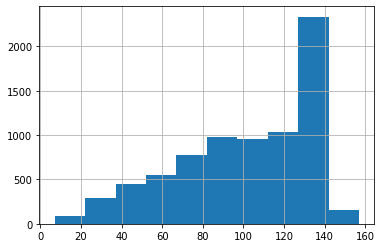

In [3]:
# Histogram of tweet lengths. I don't love the left skewed data

tweets['text'].apply(len).hist()

In [4]:
tweets.shape

(7613, 5)

In [5]:
del tweets['id']
del tweets['keyword']
del tweets['location']

In [6]:
tweets = tweets.sample(1000, random_state=42)

In [7]:
tweets

,text,target
2644,So you have a new weapon that can cause un-ima...,1
2227,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,Aftershock back to school kick off was great. ...,0
6845,in response to trauma Children of Addicts deve...,0
...,...,...
7107,@Skarletan åÇ the storm. A violent swell of em...,0
6284,Severe T-storm Warning for Union County ~3:45p...,1
131,Aftershock https://t.co/jV8ppKhJY7,0
4128,If you're gonna take a break at work.... you g...,0


# Preprocessing Tweets

In [8]:
import re

URL_REGEX = re.compile('http(s)?:\/\/t.co\/\w+')
MENTION_REGEX = re.compile('@\w+')

def clean_tweet(tweet):
    # remove mentions, the pound sign, and replace urls with URL token
    tweet = re.sub(URL_REGEX, 'url', tweet)  # replace urls with url. Assumes that the mention of a url is significant
    tweet = re.sub(MENTION_REGEX, '', tweet)  # remove mentions entirely
    tweet = tweet.replace('#', '')  # remove pound signs
    
    return tweet.strip()

In [9]:
clean_tweet('@prof_oz MEG issues Hazardous #Weather Outlook (HWO) http://t.co/3X6RBQJHn3')

'MEG issues Hazardous Weather Outlook (HWO) url'

In [10]:
tweets['text'] = tweets['text'].apply(clean_tweet)

tweets

,text,target
2644,So you have a new weapon that can cause un-ima...,1
2227,The f$&amp; things I do for GISHWHES Just got ...,0
5448,DT : RT : ÛÏThe CoL police can catch a pickpo...,1
132,Aftershock back to school kick off was great. ...,0
6845,in response to trauma Children of Addicts deve...,0
...,...,...
7107,åÇ the storm. A violent swell of emotions then...,0
6284,Severe T-storm Warning for Union County ~3:45p...,1
131,Aftershock url,0
4128,If you're gonna take a break at work.... you g...,0


<AxesSubplot:>

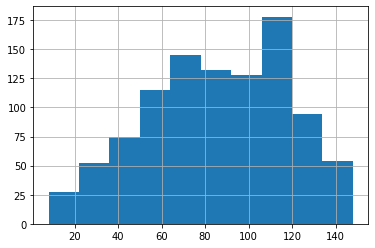

In [11]:
# Histogram of tweet lengths after cleaning. Much more normal :)

tweets['text'].apply(len).hist()

In [12]:
from nlp import load_dataset, Dataset

# the trainer is expecting a 'label' (see the forward method in the docs)
tweets['label'] = tweets['target']
del tweets['target']

tweet_dataset = Dataset.from_pandas(tweets)

# Dataset has a built in train test split method
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
BERT_MODEL = 'distilbert-base-uncased'

# reminder uncased vs cased. We are using uncased to simplify and we don't think case will matter here

In [14]:
from transformers import DistilBertTokenizer

bert_tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL)

In [15]:
# We will pad our dataset so that our input matrices are the same length and truncate anything longer than 512 tokens
def preprocess(data):
    return bert_tokenizer(data['text'], padding=True, truncation=True)

train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification

sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=2,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

In [17]:
train_set[0]

{'label': tensor(0),
 'input_ids': tensor([  101,  2002,  1005,  1055,  2893,  2753,  2182,  1045,  2228,  1012,
          5474,  1012,  8710,  1012, 14548,  1012,  1999,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0])}

In [18]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


In [19]:
batch_size = 32
epochs = 4

warmup_steps = 50
weight_decay = 0.02

training_args = TrainingArguments(
    output_dir='./clf/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    logging_dir='./clf/logs',
    logging_strategy='steps',
    logging_steps=1,
    logging_first_step=True
)

# Define the trainer: 

trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics
)

In [20]:
from torch.nn import Softmax

Softmax(dim=1)(sequence_classification_model(bert_tokenizer.encode(clean_tweet('this earthquake is awful'), return_tensors='pt')).logits)


tensor([[0.4676, 0.5324]], grad_fn=<SoftmaxBackward>)

In [21]:
# Get initial metrics
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 200
  Batch size = 32


{'eval_loss': 0.7078994512557983,
 'eval_accuracy': 0.435,
 'eval_runtime': 12.9724,
 'eval_samples_per_second': 15.417,
 'eval_steps_per_second': 0.54}

In [22]:
trainer.train()

***** Running training *****
  Num examples = 800
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 100


Step,Training Loss
1,0.745900
2,0.699100
3,0.709800
4,0.681100
5,0.696100
6,0.721700
7,0.687300
8,0.698900
9,0.699700
10,0.677800




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=100, training_loss=0.43110418871045114, metrics={'train_runtime': 592.0815, 'train_samples_per_second': 5.405, 'train_steps_per_second': 0.169, 'total_flos': 40568140838400.0, 'train_loss': 0.43110418871045114, 'epoch': 4.0})

In [23]:
# Get post-training metrics
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 200
  Batch size = 32


{'eval_loss': 0.6223104000091553,
 'eval_accuracy': 0.77,
 'eval_runtime': 8.7361,
 'eval_samples_per_second': 22.893,
 'eval_steps_per_second': 0.801,
 'epoch': 4.0}

In [24]:
Softmax(dim=1)(sequence_classification_model(bert_tokenizer.encode(clean_tweet('this earthquake is awful'), return_tensors='pt')).logits)


tensor([[0.0231, 0.9769]], grad_fn=<SoftmaxBackward>)

In [25]:
# Helper function to use our fine-tuned model

softmax = Softmax(dim=1)

def get_probability_of_disaster(tweet):
    cleaned_tweet = clean_tweet(tweet)
    results = sequence_classification_model(bert_tokenizer.encode(cleaned_tweet, return_tensors='pt'))
    probas = softmax(results.logits)
    return float(probas[0][1])


In [26]:
get_probability_of_disaster('hi')

0.10301631689071655

In [27]:
get_probability_of_disaster('this is awful. Such a bad earthquake')

0.91704922914505

In [28]:
# save model

sequence_classification_model.save_pretrained(
    './clf/results', 
    push_to_hub=False, repo_name="finetuned-disaster-model"
)

Configuration saved in ./clf/results/config.json
Model weights saved in ./clf/results/pytorch_model.bin
